In [31]:
%reload_ext autoreload
%autoreload 2

from _shared import *

NOTEBOOK_ID = '1'

## Импорт библиотек

In [32]:
import datetime as dt

import dill
import numpy as np
import pandas as pd
import seaborn as sns

from feature_engine.imputation import DropMissingData

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


import uai.data

# Загрузка данных

In [33]:
df = uai.data.load_dataset(ROOT_PATH)
print(f'Загружено случаев: {df.shape[0]}')
df.head(3)

Загружено случаев: 1468


,institution,id,gender,age,dose,date_analyse,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,pass_dose,institution_id,diagnos,sss,birthdate
0,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,0,57,7.5,2022-11-11,3.11,1,0,0,13.0,3.32,1,0,20,Фибрилляция предсердий,NaN,1965-11-11
1,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,0,57,7.5,2022-11-24,3.32,1,0,0,15.0,2.01,2,0,20,Фибрилляция предсердий,NaN,1965-11-11
2,ГБУЗ РБ Толбазинская ЦРБ,140361892057264,1,50,5.0,2022-11-22,2.01,0,1,0,26.0,2.75,1,0,20,ПротезированиеМитрального клапана,NaN,1972-11-22


## Парсинг данных - выделение по группам (оставлен код исходного парсера)
* возрастов
* диагнозов
* вычисление относительной даты анализа

In [34]:
# В файл ЦАТ_общий_parsed_extDS_v6.xlsx относительно ЦАТ_общий_parsed.xlsx
# добавлены:
# institution_id - id лечебного учреждения (на основании первого столбца с названием)
# diagnos и sss - записи о диагнозе и сердечно-сосудистых событиях из первичных файлов

# Группы диагнозов: обрабатываются поля диагнозов и сердечно-сосудистых событий
# d1 - Протезирование клапанов
# d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
# d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
# d4 - (I05-09)Ревматическая болезнь сердца
# d5 - (I35)Неревматические поражения аортального клапана
# d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
# d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
# d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)

# Группы возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

# Относительная давность анализа:
# date_from_1990 = количество дней от 01.01.1990 до date_analyse

## Функции для формирования доп.колонок (код сохранен без изменений исходного парсера).
Создаются новые столбцы по группам возрастов, по группам заболеваний и столбец с относительной давностью анализа:  date_from_1990

In [35]:
# Сформируем колонки по группам возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

def get_level(x):
# age_level	0-10-30-50-60-70-80-90+
    if x < 10 : return 0
    if x >= 10 and x < 30 : return 10
    if x >= 30 and x < 50 : return 30
    if x >= 50 and x < 60 : return 50
    if x >= 60 and x < 70 : return 60
    if x >= 70 and x < 80 : return 70
    if x >= 80 and x < 90 : return 80
    return 90

def get_level1(x):
# age_level1	0-50-65-75-80+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 80 : return 75
    return 80

def get_level2(x):
# age_level2	0-35-50-65-80+
    if x < 35 : return 0
    if x >= 35 and x < 50 : return 35
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level3(x):
# age_level3	0-50-65-75-90+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 90 : return 75
    return 90

def get_level4(x):
# age_level4	0-50-65-80
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level5(x):
# age_level5	0-50-65+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    return 65

In [36]:
# поисковые конструкции для diagnos и sss
# for d1 -диагноз или ссс содержат слово "проте"
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
# for d5-  I35,i35
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
# for d7 - аорт, митр,клап,перегор
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац

def get_d1(x):
  # for d1 -диагноз или ссс содержат слово "проте"
  wlist = ['проте']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d2(x):
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
  wlist = ['фибр', 'фебр','ФП','трепет','i48','I48','I 48']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d3(x):
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
  wlist = ['порок','ИБС','склероз','ОИМ','инфаркт','миокард','стенокар','I20',
           'I25','ПИКС','пикс','ишемич','кард','ВПС','ОКС','стенокард',
           'ТИА','эндокардит','порок']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d4(x):
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
  wlist = ['I 08','I05','i05','i08','I06','I09','ревмат']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d5(x):
# for d5-  I35,i35
  wlist = ['I35','i35']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d6(x):
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
  wlist = ['ДКМП', 'I42', 'ОНМК','i34','Q231','ГБ','легочн','ТЭЛА']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d7(x):
# for d7 - аорт, митр,клап,перегор
  wlist = ['аорт', 'митр','клап','перегор']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d8(x):
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац
  wlist = ['АКШ','МКШ','шунт','стент','ЭКС','РЧА','аблац']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

In [37]:
def add_date_from_1990(df):
    # Вычисли относительную давность анализа:
    # сформируем колонку date_from_1990 = количество дней от 01.01.1990 до date_analyse
    date_19900101 = dt.datetime(1990, 1, 1)

    df['date_from_1990'] = (df['date_analyse'] - date_19900101).dt.days
    return df

In [38]:
def add_age_levels(df):
    """
    Сформируем колонки по группам возрастов: на основе поля возраст
        age_level	0-10-30-50-60-70-80-90+
        age_level1	0-50-65-75-80+
        age_level2	0-35-50-65-80+
        age_level3	0-50-65-75-90+
        age_level4	0-50-65-80
        age_level5	0-50-65+
        age_level6	0-65+
    """
    df['age_level'] = df['age'].apply(get_level)
    df['age_level1'] = df['age'].apply(get_level1)
    df['age_level2'] = df['age'].apply(get_level2)
    df['age_level3'] = df['age'].apply(get_level3)
    df['age_level4'] = df['age'].apply(get_level4)
    df['age_level5'] = df['age'].apply(get_level5)
    df['age_level6'] = np.where((df.age>=65), 65, 0)

    return df

## Сформируем колонки по диагнозам и ССС

In [39]:
def add_diagnosis_and_sss(df):
    """
    Сформируем колонки по диагнозам и ССС: на основе колонок diagnos, sss
        d1 - Протезирование клапанов
        d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
        d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
        d4 - (I05-09)Ревматическая болезнь сердца
        d5 - (I35)Неревматические поражения аортального клапана
        d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
        d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
        d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)
    """
    # приводим к типу 'str'
    df['diagnos'] = df['diagnos'].astype(str)
    df['sss'] = df['sss'].astype(str)

    df['d1'] = df.apply(lambda x: get_d1(x), axis=1)
    df['d2'] = df.apply(lambda x: get_d2(x), axis=1)
    df['d3'] = df.apply(lambda x: get_d3(x), axis=1)
    df['d4'] = df.apply(lambda x: get_d4(x), axis=1)
    df['d5'] = df.apply(lambda x: get_d5(x), axis=1)
    df['d6'] = df.apply(lambda x: get_d6(x), axis=1)
    df['d7'] = df.apply(lambda x: get_d7(x), axis=1)
    df['d8'] = df.apply(lambda x: get_d8(x), axis=1)

    return df

## Расчет статистических метрик по столбцу age. Анализ распределения возраста пациентов

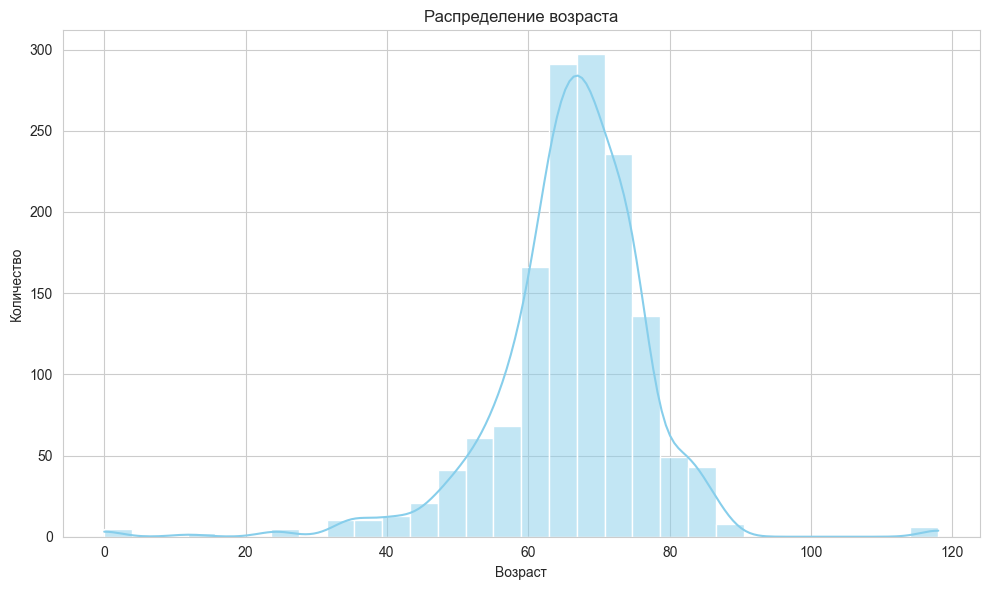

In [40]:
def plot_age_hist(ages):
    """
    Гистограмма распределения возраста.
    """
    # Белый фон с сеткой
    sns.set_style("whitegrid")

    plt.figure(figsize=(10, 6))
    sns.histplot(ages, bins=30, kde=True, color="skyblue")
    plt.title('Распределение возраста')
    plt.xlabel('Возраст')
    plt.ylabel('Количество')
    plt.tight_layout()

plot_age_hist(df['age'].copy())

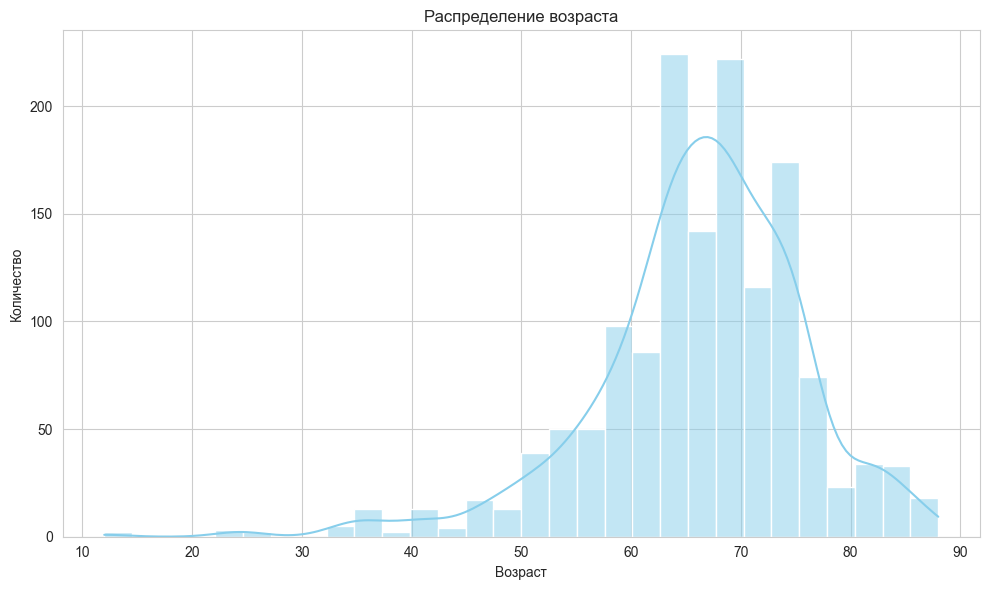

In [41]:
def remove_age_errors(df):
    """
    Удаляем явные ошибки из датасета: возраст 0 и больше 100.
    """
    df = df.drop(df[(df['age'] == 0) | (df['age'] > 100)].index)
    return df

data_age_fixed = remove_age_errors(df.copy())
plot_age_hist(data_age_fixed['age'])

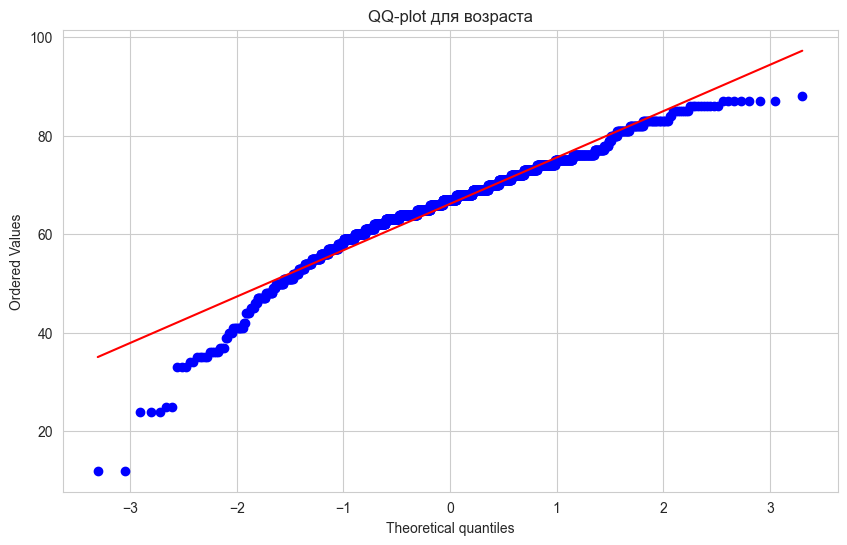

In [42]:
# QQ-plot - это графический инструмент, который помогает определить, насколько близки данные к некоторому теоретическому распределению,
# чаще всего к нормальному. Если распределение идеально совпадает с нормальным, то точки на QQ-plot будут следовать прямой линии (45-градусной)

import scipy.stats as stats

def plot_age_qq(series):
    plt.figure(figsize=(10, 6))
    stats.probplot(series, plot=plt)
    plt.title('QQ-plot для возраста')

plot_age_qq(data_age_fixed['age'])

In [43]:
# Тест Андерсона-Дарлинга

result = stats.anderson(data_age_fixed['age'])

print(f"Anderson-Darling Test: Statistic={result.statistic}")
print("Critical values:", result.critical_values)
print("Significance levels:", result.significance_level)

Anderson-Darling Test: Statistic=15.66016396291252
Critical values: [0.574 0.654 0.785 0.915 1.089]
Significance levels: [15.  10.   5.   2.5  1. ]


Результат тестов показывает, что что распределение данных в столбце 'age' не следует нормальному распределению. Прямое применение стандартных методов машинного обучения может не давать оптимальных результатов, так как большинство методов предполагает, что признаки имеют некое стандартное или нормальное распределение. Но есть модели, устойчивые к несбалансированным данным: модели на основе деревьев хорошо работают с такими данными.

Для дальнейшей оценки кореляции и принятия решения о включении в датасет на базе занных о возрасте рассчитываются следующие статистические показатели  (можно использовать другие):

**deviation_from_median**: Отклонение возраста от медианного значения возраста в датасете. Если значение положительное, возраст выше медианы; если отрицательное — ниже медианы.

**age_percentile**: Процентное положение возраста относительно всех остальных возрастов в наборе данных. Он показывает, сколько процентов людей в датасете имеют возраст ниже данного значения.

**age_quantile**: Показатель делит возраста на четыре равные части (квартили). При этом значение 1 соответствует самому нижнему квартилю (25% самых молодых), а 4 — самому верхнему квартилю (25% самых старых).

**is_elderly**: Бинарный параметр показывает, превышает ли возраст заданный порог. Если да, то значение равно 1, в противном случае — 0.

**age_density**: Оценка плотности вероятности для каждого возраста в датасете показывает, насколько "обычным" или "редким" является определенный возраст среди всех возрастов в датасете.

**age_zscore**: Z-оценка для возраста показывает, на сколько стандартных отклонений конкретное значение возраста отклоняется от среднего значения возраста в ндатасете. Если Z-оценка положительна, возраст выше среднего, и наоборот.

In [44]:
def add_age_statistics(df):
    df['deviation_from_median'] = df['age'] - df['age'].median()
    df['age_percentile'] = df['age'].apply(lambda x: stats.percentileofscore(df['age'], x))
    df['age_quantile'] = pd.qcut(df['age'], q=4, labels=[1, 2, 3, 4])

    threshold = 70
    df['is_elderly'] = (df['age'] > threshold).astype(int)

    df['age_density'] = df['age'].apply(lambda x: float(stats.gaussian_kde(df['age'])(x)))

    mean_age = df['age'].mean() # средний возраст
    std_age = df['age'].std() # стандартное отклонение
    df['age_zscore'] = (df['age'] - mean_age) / std_age

    return df

## Cоздание дополнительные признаков

In [45]:
# Функция Отклонение (лет) от критического возраста: critical_age_l - младше порога; critical_age_h - старше порога

critical_age_threshold = 40  # принятый порог критического возраста

def critical_age(df,tr_age=critical_age_threshold):
    if 'age' in df.columns and 'int' in df.age.dtype.name:
        df['critical_age_l']=df['age'].apply(lambda x: tr_age - x if x < tr_age else 0 ).astype('int8')
        df['critical_age_h']=df['age'].apply(lambda x: x - tr_age if x > tr_age else 0  ).astype('int8')
    return df

In [46]:
# Функция make_ohe_columns - развертывание значений категориальных колнок в One-Hot-Encoded векторы

def make_ohe_columns(df):

    # Список колонок для развертывания в OHE векторы
    # features_to_ohe = ['gender', 'institution_id', 'abracadabra']  # test
    features_to_ohe = ['gender', 'institution_id']

    cols = [c for c in list(features_to_ohe) if c in df.columns]

    return pd.get_dummies(df, columns=cols, drop_first=False)


# test

# clear_df = make_ohe_columns(df.copy())
# clear_df.head(3)

In [47]:
# Разбиение возраста по корзинам
# Функция назначения номера возрастной группы по значению возраста

def add_age_bins(df, ohe=True):
    def bin_age_x(a):
        x = a // 10
        x = 9 if x > 9 else x
        return x

    if 'age' in df.columns and 'int' in df.age.dtype.name:
        df['agebin']=df['age'].apply(lambda x: bin_age_x(x)).astype('int8')
        df = pd.get_dummies(df, columns=['agebin'], drop_first=False) if ohe else df
    return df

### Добавление названий имен знаков зодиака

In [48]:
# Загрузка пакета и функции генерации

from zodiac_sign import get_zodiac_sign

In [49]:
# Разбиение OHE по знакам зодиака

def make_zodiac_ohe(df):
    if 'birthdate' in df.columns:
        df['zodiac'] = df['birthdate'].apply(lambda x: get_zodiac_sign(x))
        df = pd.get_dummies(df, columns=['zodiac'], drop_first=False )
    return df

In [50]:
# Дополнительный признак (изменение МНО) (Андрей)

def add_trend(df):
    df['trend'] = df['INR(MHO)'] - df['prev_INR(MHO)']
    return df

## Собираем написанные ранее функции в пайплайн

In [51]:
# Рецепт, по которому очищаем и обогащаем набор данных

data_pipeline_wide = make_pipeline(
    FunctionTransformer(add_date_from_1990),
    FunctionTransformer(add_age_levels),
    FunctionTransformer(add_diagnosis_and_sss),
    FunctionTransformer(remove_age_errors),
    FunctionTransformer(add_age_statistics),
    FunctionTransformer(critical_age),
    FunctionTransformer(add_age_bins),
    FunctionTransformer(make_zodiac_ohe),
    FunctionTransformer(make_ohe_columns),
    FunctionTransformer(uai.data.bool_to_int8_in_df),
)

# Настраиваем (fit) пайплайн и сохраняем его в файл
data_pipeline_wide.fit(df)
with open(ROOT_PATH / f'models/data_pipeline_wide_{NOTEBOOK_ID}.dill', 'wb') as f:
    dill.dump(data_pipeline_wide, f, recurse=True)

data_pipeline_wide

C:\Users\victk\AppData\Local\Temp\ipykernel_6648\1052260012.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['age_density'] = df['age'].apply(lambda x: float(stats.gaussian_kde(df['age'])(x)))


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function add_date_from_1990 at 0x0000022D40CF1DA0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function add_age_levels at 0x0000022D40CF2200>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function add_diagnosis_and_sss at 0x0000022D40CF22A0>)),
                ('functiontransformer-4',
                 Functio...
                 FunctionTransformer(func=<function add_age_bins at 0x0000022D41005940>)),
                ('functiontransformer-8',
                 FunctionTransformer(func=<function make_zodiac_ohe at 0x0000022D41062C00>)),
                ('functiontransformer-9',
                 FunctionTransformer(func=<function make_ohe_columns at 0x0000022D41062F20>)),
                ('functiontransformer-10',
                 FunctionTransformer(func=<function bool_to_int8_in_df at 0x0000022D401F1A80>))])

In [52]:
# Преобразуем исходные данные согласно рецепту и сохраняем результат в файл

df = uai.data.load_dataset(ROOT_PATH)
data_wide = data_pipeline_wide.transform(df)

data_wide.to_csv(ROOT_PATH / f'data/processed/data_wide_{NOTEBOOK_ID}.csv', index=False)
data_wide.head(3)

C:\Users\victk\AppData\Local\Temp\ipykernel_6648\1052260012.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['age_density'] = df['age'].apply(lambda x: float(stats.gaussian_kde(df['age'])(x)))


,institution,id,age,dose,date_analyse,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,57,7.5,2022-11-11,3.11,1,0,0,13.0,...,0,0,0,0,0,0,0,0,0,0
1,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,57,7.5,2022-11-24,3.32,1,0,0,15.0,...,0,0,0,0,0,0,0,0,0,0
2,ГБУЗ РБ Толбазинская ЦРБ,140361892057264,50,5.0,2022-11-22,2.01,0,1,0,26.0,...,0,0,0,0,0,0,0,0,0,0


# Полный pipeline для обработки данных
1. Создаем пайплайн
2. Пропускаем через него исходные данные
3. Сохраняем результат - данные, которые будут использоваться моделями




In [53]:
def remove_unrelated_features(df):
    """
    Удаляем столбцы, которые не влияют на дозу варфарина или переведены
    в иные числовые параметры.
    """
    return df.drop(
        ['institution', 'date_analyse', 'diagnos', 'sss', 'date_from_1990', 'birthdate'],
        axis=1
    )

In [54]:
# Удаляем ненужные колонки (Андрей)

def remove_features(df):
    # Опытным путем проверено, что наибольшая точность получается, если удалить из X
    # следующий набор колонок:
    features2remove = ['pass_dose', 'sample', 'date_diff']
    return df.drop(columns=features2remove, axis=1)

In [55]:
data_pipeline = make_pipeline(
    *data_pipeline_wide,
    FunctionTransformer(remove_unrelated_features),
    # FunctionTransformer(remove_features, kw_args={'column_names': features_to_remove}),
    DropMissingData(),
    FunctionTransformer(uai.data.bool_to_int8_in_df)
)

# Настраиваем (fit) пайплайн и сохраняем его в файл
data_pipeline.fit(df)
with open(ROOT_PATH / f'models/data_pipeline_{NOTEBOOK_ID}.dill', 'wb') as f:
    dill.dump(data_pipeline, f, recurse=True)

data_pipeline

C:\Users\victk\AppData\Local\Temp\ipykernel_6648\1052260012.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['age_density'] = df['age'].apply(lambda x: float(stats.gaussian_kde(df['age'])(x)))


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function add_date_from_1990 at 0x0000022D40CF1DA0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function add_age_levels at 0x0000022D40CF2200>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function add_diagnosis_and_sss at 0x0000022D40CF22A0>)),
                ('functiontransformer-4',
                 Functio...
                ('functiontransformer-10',
                 FunctionTransformer(func=<function bool_to_int8_in_df at 0x0000022D401F1A80>)),
                ('functiontransformer-11',
                 FunctionTransformer(func=<function remove_unrelated_features at 0x0000022D41078540>)),
                ('dropmissingdata', DropMissingData()),
                ('functiontransformer-12',
                 FunctionTransformer(func=<function bool_to_int8_in_df at 0x0000022D401F1A80>))])

In [56]:
# Пропускаем исходные данные через сконструированный выше пайплайн.
# Результат будем использовать для обучения моделей.

# Загружаем данные из файла (для надежности)
df = uai.data.load_dataset(ROOT_PATH)
data_for_model = data_pipeline.transform(df)

data_for_model.to_csv(ROOT_PATH / f'data/processed/data_for_model_{NOTEBOOK_ID}.csv', index=False)
data_for_model.head(3)

C:\Users\victk\AppData\Local\Temp\ipykernel_6648\1052260012.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['age_density'] = df['age'].apply(lambda x: float(stats.gaussian_kde(df['age'])(x)))


,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13.0,3.32,1,...,0,0,0,0,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15.0,2.01,2,...,0,0,0,0,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26.0,2.75,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1456 entries, 0 to 1467
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     1456 non-null   int64   
 1   age                    1456 non-null   int64   
 2   dose                   1456 non-null   float64 
 3   prev_INR(MHO)          1456 non-null   float64 
 4   atrial_fibrillation    1456 non-null   int64   
 5   mitral_valve           1456 non-null   int64   
 6   aortal_valve           1456 non-null   int64   
 7   date_diff              1456 non-null   float64 
 8   INR(MHO)               1456 non-null   float64 
 9   sample                 1456 non-null   int64   
 10  pass_dose              1456 non-null   int64   
 11  age_level              1456 non-null   int64   
 12  age_level1             1456 non-null   int64   
 13  age_level2             1456 non-null   int64   
 14  age_level3             1456 non-null   int64 

In [58]:
# Если ничего не напечаталось - то не дошли сюда, и где-то в ноутбуке ошибка
import datetime as dt
print('Ноутбук завершен:', dt.datetime.now())

Ноутбук завершен: 2023-11-05 02:39:55.363336
